In [14]:
#ローカルレベルモデルのスクラッチ実装
#基本的なデータセットのみ取得
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import minimize
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

from matplotlib import pylab as plt
import seaborn as sns
sns.set()

In [15]:
#予測するデータを作る
np.random.seed(1)
sim_size = 100

#make random walk process
mu = np.cumsum(stats.norm.rvs(loc=0, scale=5, size=sim_size).round(1)) + 30

#make obs
y = mu + stats.norm.rvs(loc=0, scale=5, size=sim_size).round(1)

#make time index
y_ts = pd.Series(y, index=pd.date_range(start='2020-01-01', periods=sim_size, freq='D'))

<Axes: >

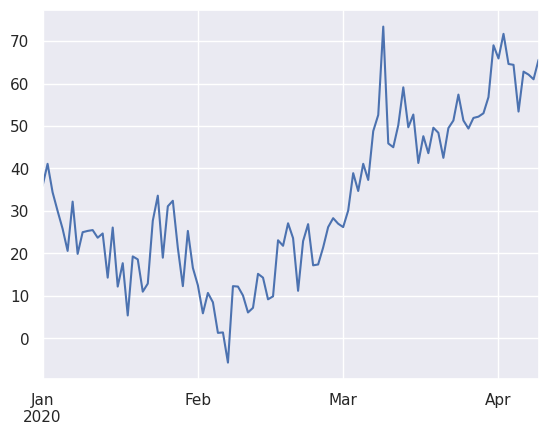

In [16]:
y_ts.plot()

In [23]:
#local level class

class LocalLevel:
  #storage dataset and make sum zeros dataset, a is state, P is V of State, v is gap of obs and estimated obs,
  #F is P + V of obs, K is is Kalman Gain, s_level is V of state, s_irregular is V of obs

  #make initializer
  def __init__(self, ts_data):
    self.ts_data = ts_data
    self.a = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
    self.P = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
    self.v = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
    self.F = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
    self.K = pd.Series(np.zeros(len(ts_data)), index=ts_data.index)
    self.s_level = None
    self.s_irregular = None

  #set initial function, you can set initial a and P.
  def initialize(self, initial_a, initial_P):
    self.initial_a = initial_a
    self.initial_P = initial_P

  #Predict one point ahead function
  def _forecast_step(self, a_pre, P_pre, s_irregular, s_level, first=False):
    #first step, you use initial a and P
    if first:
      a_forecast = self.initial_a
      P_forecast = self.initial_P
    else:
      a_forecast = a_pre
      P_forecast = P_pre + s_level

    y_forecast = a_forecast
    F = P_forecast + s_irregular

    return(pd.Series([a_forecast, P_forecast, y_forecast, F], index=['a', 'P', 'y', 'F']))

  #Filter mothod
  def _filter_step(self, forecasted, y, s_irregular):
    v = y - forecasted.y
    K = forecasted.P / forecasted.F
    a_filter = forecasted.a + K * v
    P_filter = (1 - K) * forecasted.P

    return(pd.Series([a_filter, P_filter, v, K], index=['a', 'P', 'v', 'K']))

  def filter(self, s_irregular, s_level):
    for i in range(0, len(self.ts_data)):
      if(i == 0):
        #初回は任意の初期値を利用.forecast_step関数に引数を渡し、forecast_loopにforecast_stepの出力を保存
        forecast_loop = self._forecast_step(
            a_pre=None, P_pre=None, s_irregular=s_irregular, s_level=s_level, first=True
        )
      else:
        #1時点前の値を参照して予測する。forecast_step関数に引数を渡し、forecast_loopにforecast_stepの出力を保存
        forecast_loop = self._forecast_step(
            a_pre=self.a.iloc[i - 1], P_pre=self.P.iloc[i - 1],
            s_irregular=s_irregular, s_level=s_level
        )
      #フィルタリング実行。filter_stepの引数を渡す。フィルタリングされた値がfilter_loopに戻される。
      filter_loop = self._filter_step(
          forecasted=forecast_loop, y=self.ts_data.iloc[i], s_irregular=s_irregular
      )

      #結果の保存
      self.a.iloc[i] = filter_loop.a
      self.P.iloc[i] = filter_loop.P
      self.F.iloc[i] = forecast_loop.F
      self.K.iloc[i] = filter_loop.K
      self.v.iloc[i] = filter_loop.v

  #対数尤度関数
  def llf(self):
    return np.sum(np.log(stats.norm.pdf(
        x=self.v, loc=0, scale=np.sqrt(self.F)
        )))

  #最尤法によるパラメータ推定.フィルター関数にs_irregularとs_levelをセットしてみて、対数尤度を算出
  def fit(self, start_params):
    def calc_llf(params):
      self.filter(np.exp(params[0], np.exp(params[1])))
      return self.llf() * -1

    opt_res = minimize(calc_llf, start_params,
                       method='Nelder-Mead', tol=1e-6, options={'maxiter':2000})

    #params storage

    self.s_irregular = np.exp(opt_res.x[0])
    self.s_level = np.exp(opt_res[1])

    self.filter(self.s_irregular, self.s_level)

  #可視化
  def plot_level(self):
    plot_df = pd.concat([self.a, self.ts_data], axis=1)
    plot_df.columns = column=['filtered', 'y']
    plot_df.plot()

In [24]:
local_level = LocalLevel(y_ts)

local_level.initialize(initial_a=0, initial_P=1000000)

local_level.filter(s_irregular=10, s_level=1)

In [25]:
local_level.a.round(5).head(3)

,0
2020-01-01,35.89964
2020-01-02,38.62363
2020-01-03,37.00106


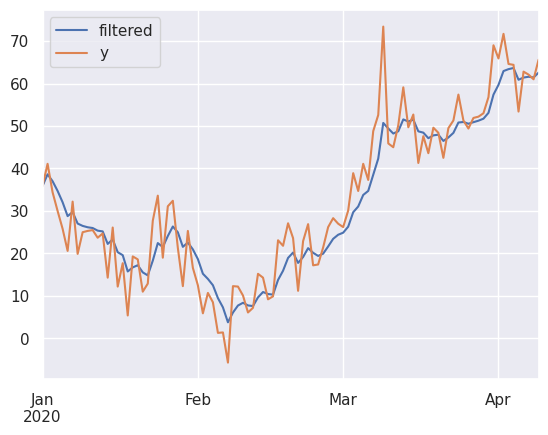

In [26]:
local_level.plot_level()